In [1]:
import warnings
warnings.filterwarnings("ignore")

# 1. Simulating Local Data Clustering

This code demonstrates how different clients might perform local clustering on their datasets.

In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs   # it can create fake(synthetic) data
 
# Simulate data for different clients
def create_client_data(n_samples, n_features, centers, cluster_std, random_state):
    X, _ = make_blobs(n_samples = n_samples, n_features = n_features, centers = centers, cluster_std = cluster_std, random_state = random_state)
    return X

# Each client clusters their own data
def client_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    kmeans.fit(data)
    return kmeans

# Example of local data for two clients
client1_data = create_client_data(100, 2, centers = 3, cluster_std = 1.0, random_state = 42)
client2_data = create_client_data(100, 2, centers = 4, cluster_std = 1.5, random_state = 52)

# Perform clustering
client1_model = client_clustering(client1_data, n_clusters = 3)
client2_model = client_clustering(client2_data, n_clusters = 4)

# 2. Sharing and Comparing Models

This example simulates how clients might share and compare their models using reconstruction error.

In [5]:
from sklearn.metrics import pairwise_distances_argmin_min

# Function to compare models using reconstruction error
def reconstruction_error(client_model, other_client_data):
    closest, _ = pairwise_distances_argmin_min(client_model.cluster_centers_, other_client_data)
    return closest

# Simulate model sharing and comparison
client1_error = reconstruction_error(client1_model, client2_data)
client2_error = reconstruction_error(client2_model, client1_data)

print("Client 1 Reconstruction Error:", client1_error)
print("Client 2 Reconstruction Error:", client2_error)

Client 1 Reconstruction Error: [38  4 63]
Client 2 Reconstruction Error: [64 39 59 92]


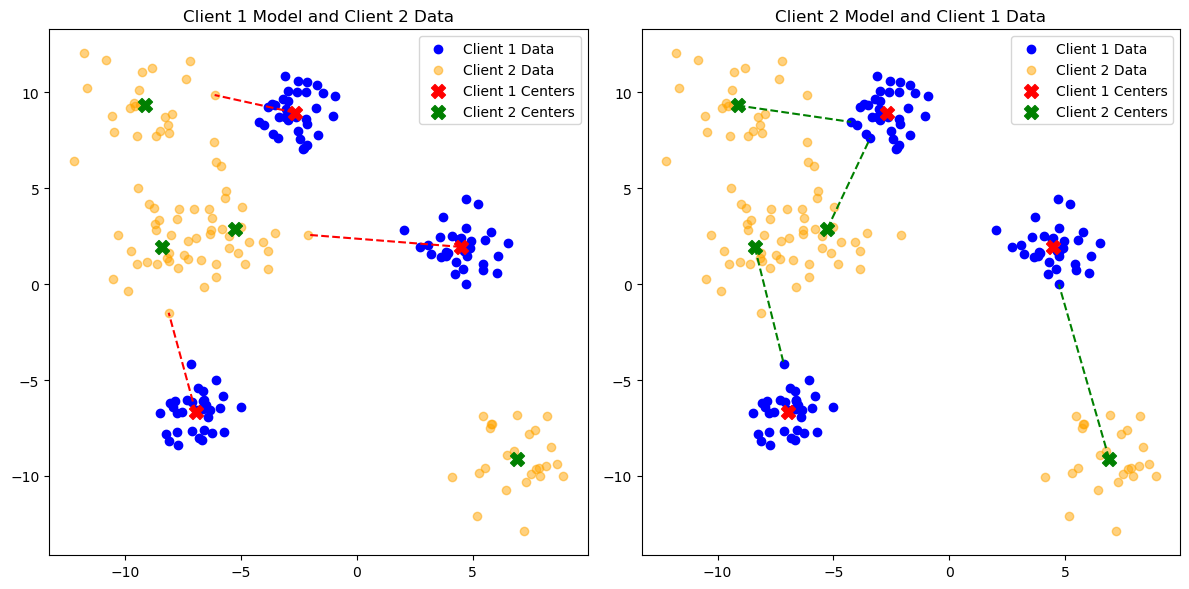

In [6]:
import matplotlib.pyplot as plt

# Visualization
plt.figure(figsize=(12, 6))

# Plot client 1 data and its cluster centers
plt.subplot(1, 2, 1)
plt.scatter(client1_data[:, 0], client1_data[:, 1], color = 'blue', label= 'Client 1 Data')
plt.scatter(client2_data[:, 0], client2_data[:, 1], color = 'orange', label= 'Client 2 Data', alpha = 0.5)
plt.scatter(client1_model.cluster_centers_[:, 0], client1_model.cluster_centers_[:, 1], color = 'red', marker='X', s = 100, label = 'Client 1 Centers')
plt.scatter(client2_model.cluster_centers_[:, 0], client2_model.cluster_centers_[:, 1], color = 'green', marker='X', s = 100, label = 'Client 2 Centers')

# Draw lines for Client 1 model's reconstruction error on Client 2 data
for i, (center, closest_idx) in enumerate(zip(client1_model.cluster_centers_, client1_error)):
    plt.plot([center[0], client2_data[closest_idx, 0]], [center[1], client2_data[closest_idx, 1]], 'r--')

plt.title("Client 1 Model and Client 2 Data")
plt.legend()

# Plot client 2 data and its cluster centers
plt.subplot(1, 2, 2)
plt.scatter(client1_data[:, 0], client1_data[:, 1], color = 'blue', label = 'Client 1 Data')
plt.scatter(client2_data[:, 0], client2_data[:, 1], color = 'orange', label = 'Client 2 Data', alpha=0.5)
plt.scatter(client1_model.cluster_centers_[:, 0], client1_model.cluster_centers_[:, 1], color = 'red', marker = 'X', s = 100, label = 'Client 1 Centers')
plt.scatter(client2_model.cluster_centers_[:, 0], client2_model.cluster_centers_[:, 1], color = 'green', marker = 'X', s = 100, label = 'Client 2 Centers')

# Draw lines for Client 2 model's reconstruction error on Client 1 data
for i, (center, closest_idx) in enumerate(zip(client2_model.cluster_centers_, client2_error)):
    plt.plot([center[0], client1_data[closest_idx, 0]], [center[1], client1_data[closest_idx, 1]], 'g--')

plt.title("Client 2 Model and Client 1 Data")
plt.legend()

plt.tight_layout()
plt.show()


# 3. Federated Clustering (Combining Models)
This snippet demonstrates a basic approach to combine models from different clients, refining clusters in a federated manner.

In [8]:
# Combine cluster centers from both clients
combined_centers = np.vstack((client1_model.cluster_centers_, client2_model.cluster_centers_))

# Perform a new clustering on combined centers
final_model = KMeans(n_clusters=len(combined_centers), random_state=42)
final_model.fit(combined_centers)
final_centers = final_model.cluster_centers_

print("Final Cluster Centers:\n", final_model.cluster_centers_)

Final Cluster Centers:
 [[ 4.49951001  1.93892013]
 [-5.2703863   2.87806748]
 [-6.95170962 -6.67621669]
 [ 6.90209476 -9.10606436]
 [-2.66780392  8.93576069]
 [-9.13887282  9.31251918]
 [-8.39838001  1.92358436]]


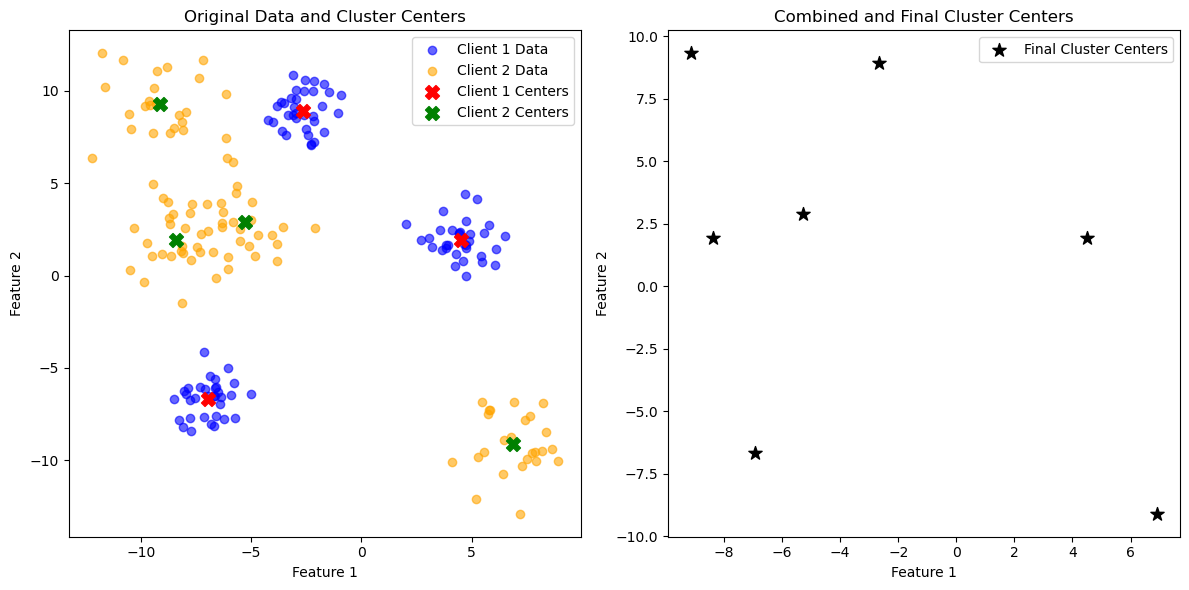

In [9]:
# Visualization
plt.figure(figsize=(12, 6))

# Plot original data and cluster centers
plt.subplot(1, 2, 1)
plt.scatter(client1_data[:, 0], client1_data[:, 1], color = 'blue', label = 'Client 1 Data', alpha = 0.6)
plt.scatter(client2_data[:, 0], client2_data[:, 1], color = 'orange', label = 'Client 2 Data', alpha = 0.6)
plt.scatter(client1_model.cluster_centers_[:, 0], client1_model.cluster_centers_[:, 1], color = 'red', marker = 'X', s = 100, label = 'Client 1 Centers')
plt.scatter(client2_model.cluster_centers_[:, 0], client2_model.cluster_centers_[:, 1], color = 'green', marker = 'X', s = 100, label = 'Client 2 Centers')
plt.title("Original Data and Cluster Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

# Plot combined centers and new cluster centers
plt.subplot(1, 2, 2)
plt.scatter(final_centers[:, 0], final_centers[:, 1], color = 'black', marker = '*', s = 100, label = 'Final Cluster Centers')
plt.title("Combined and Final Cluster Centers")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()

plt.tight_layout()
plt.show()

# 4. Validation and Comparison with Centralized Method
This snippet compares the performance of the federated approach with a traditional centralized clustering method.

In [11]:
from sklearn.metrics import silhouette_score    # evaluate the quality of clustering results (range between -1 to +1)

# Centralized clustering for comparison
centralized_data = np.vstack((client1_data, client2_data))
centralized_model = KMeans(n_clusters=7, random_state=42)  # Assuming 7 is the global K
centralized_model.fit(centralized_data)

# Calculate Silhouette Scores for comparison
# For federated approach, we should use the combined data and the labels assigned by the final model
# We need to re-cluster the combined data with the number of clusters found in final_model for correct comparison
combined_labels = centralized_model.fit_predict(centralized_data)

federated_score = silhouette_score(centralized_data, combined_labels)

# For centralized approach
centralized_score = silhouette_score(centralized_data, centralized_model.labels_)

print("Federated Silhouette Score:", round(federated_score * 100, 2), "%")
print("Centralized Silhouette Score:", round(centralized_score * 100, 2), "%")

Federated Silhouette Score: 63.8 %
Centralized Silhouette Score: 63.8 %
